In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *; from tools.generalTools import *; from tools.BLtools import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

 - Load daily w and correlate to U. Then temp. budget.
 - is $B_L$ from monthly avgs better than monthly avgd $B_L$ to predict precip?

# Functions, data loading

In [2]:
# Monthly data
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81

gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-202012.nc")

era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2020.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2020.nc")

era5sst_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.128_034_sstk.2001-2020.nc")
era5sst_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.128_034_sstk.2001-2020.nc")


In [3]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"New Britain"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])


In [9]:
MRs = Ghats      ,Myanmar    ,Vietnam    ,Malaysia   ,Philippines,Newbritain 
    


# Single day test

In [5]:
%%time
path = "/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/202007/"
gz = sel_box(xr.open_dataset(path+"e5.oper.an.pl.128_129_z.ll025sc.2020070100_2020070123.nc").Z,Ghats.box)
t  = sel_box(xr.open_dataset(path+"e5.oper.an.pl.128_130_t.ll025sc.2020070100_2020070123.nc").T,Ghats.box)
u  = sel_box(xr.open_dataset(path+"e5.oper.an.pl.128_131_u.ll025uv.2020070100_2020070123.nc").U,Ghats.box)
v  = sel_box(xr.open_dataset(path+"e5.oper.an.pl.128_132_v.ll025uv.2020070100_2020070123.nc").V,Ghats.box)
w  = sel_box(xr.open_dataset(path+"e5.oper.an.pl.128_135_w.ll025sc.2020070100_2020070123.nc").W,Ghats.box)

CPU times: user 88 ms, sys: 55.4 ms, total: 143 ms
Wall time: 31.3 s


In [16]:
dTdt = t.differentiate('time')*1e9 # K/s
udTdx = u*ddx(t)
vdTdy = v*ddy(t)
s = t + gz/1004.
omegadsdp = w*s.differentiate('level')/100
residual = dTdt+udTdx+vdTdy+omegadsdp

In [ ]:
K/s -> K/s*kg/m2 -> J/m2/s -> kg/m2/s -> *3600

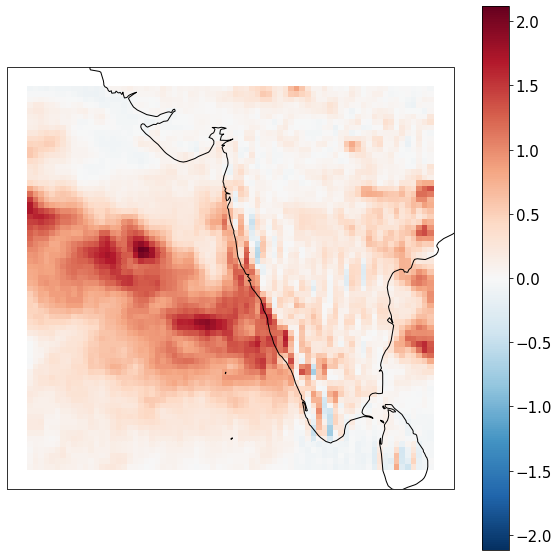

In [33]:
_,ax=plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
(residual.mean('time').integrate('level')*100/9.81 * 1004./2.5e6*3600).plot(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()

In [22]:
test = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.accumulated_tp_1h/e5.accumulated_tp_1h.202007.nc")

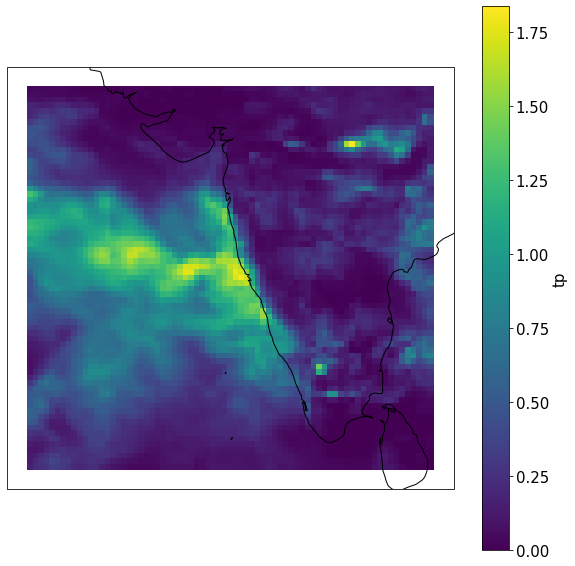

In [31]:
_,ax=plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
(sel_box(test.tp,Ghats.box)[:24].mean('time')*1e3).plot(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()

# On monthly time scales

In [88]:
%%time
path = "/global/cfs/cdirs/m3310/wboos/ERA5_1950-1978/"
m=6 #July
gz = sel_box(xr.open_dataset(path+"e5.moda.an.pl/e5.moda.an.pl.128_129_z.ll025sc.1978010100_1978120100.nc").z[m],Ghats.box)
t  = sel_box(xr.open_dataset(path+"e5.moda.an.pl/e5.moda.an.pl.128_130_t.ll025sc.1978010100_1978120100.nc").t[m],Ghats.box)
u  = sel_box(xr.open_dataset(path+"e5.moda.an.pl/e5.moda.an.pl.128_131_u.ll025sc.1978010100_1978120100.nc").u[m],Ghats.box)
v  = sel_box(xr.open_dataset(path+"e5.moda.an.pl/e5.moda.an.pl.128_132_v.ll025sc.1978010100_1978120100.nc").v[m],Ghats.box)
w  = sel_box(xr.open_dataset(path+"e5.moda.an.pl/e5.moda.an.pl.128_135_w.ll025sc.1978010100_1978120100.nc").w[m],Ghats.box)
ps = sel_box(xr.open_dataset(path+"e5.moda.an.sfc/e5.moda.an.sfc.128_134_sp.ll025sc.1978010100_1978120100.nc").sp[m],Ghats.box)
pr = sel_box(xr.open_dataset(path+"e5.moda.fc.sfc.accumu/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1978010100_1978120100.nc").tp[m],Ghats.box)
shf = sel_box(xr.open_dataset(path+"e5.moda.fc.sfc.accumu/e5.moda.fc.sfc.accumu.128_146_sshf.ll025sc.1978010100_1978120100.nc").sshf[m],Ghats.box)
lhf = sel_box(xr.open_dataset(path+"e5.moda.fc.sfc.accumu/e5.moda.fc.sfc.accumu.128_147_slhf.ll025sc.1978010100_1978120100.nc").slhf[m],Ghats.box)
netssw = sel_box(xr.open_dataset(path+"e5.moda.fc.sfc.accumu/e5.moda.fc.sfc.accumu.128_176_ssr.ll025sc.1978010100_1978120100.nc").ssr[m],Ghats.box)
netslw = sel_box(xr.open_dataset(path+"e5.moda.fc.sfc.accumu/e5.moda.fc.sfc.accumu.128_177_str.ll025sc.1978010100_1978120100.nc").str[m],Ghats.box)
nettsw = sel_box(xr.open_dataset(path+"e5.moda.fc.sfc.accumu/e5.moda.fc.sfc.accumu.128_178_tsr.ll025sc.1978010100_1978120100.nc").tsr[m],Ghats.box)
nettlw = sel_box(xr.open_dataset(path+"e5.moda.fc.sfc.accumu/e5.moda.fc.sfc.accumu.128_179_ttr.ll025sc.1978010100_1978120100.nc").ttr[m],Ghats.box)

netradiative = (nettsw+nettlw - (netssw+netslw))/86400
sfcfluxes = - (shf+lhf)/86400
pr_Wm2 = pr*1e3/86400*2.5e6


CPU times: user 99.6 ms, sys: 4.34 ms, total: 104 ms
Wall time: 373 ms


In [89]:
def p_k_half_era5(ps):
    """Given a surface pressure in Pa,
    return the pressure level p_{k+1/2} from which to compute the surface part 
    of the integral (see SeagerHenderson2013 - eq (22))
    args :
     - ps (float) : surface pressure in Pa
     
     Namely, finds the pressure levels p_k and p_{k+1} such that pk <= ps < p_{k+1}
     and returns (p_k + p_{k+1})/2; if ps >= 1e5 Pa = 1000 hPa, returns 1e5 Pa
    """
    plevs = 100.*np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70.,
        100., 125., 150., 175., 200., 225., 250., 300., 350., 400.,
        450., 500., 550., 600., 650., 700., 750., 775., 800., 825.,
        850., 875., 900., 925., 950., 975., 1000.])
    
    return (plevs[np.searchsorted(plevs,ps)-1]+
            plevs[np.minimum(np.searchsorted(plevs,ps),len(plevs)-1)])/2


def compute_vertical_integral(var,ps):
    var_vinteg = ((var*(100*var.level<ps)).integrate("level")*100 +
                 (var.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half_era5,ps))  
                 )#sfc_term = uq_k * (p_s - p_{k+1/2})
                )
    return var_vinteg
    

In [90]:
udTdx = u*ddx(t)
vdTdy = v*ddy(t)
s = t + gz/1004.
omegadsdp = w*s.differentiate('level')/100
residual = udTdx+vdTdy+omegadsdp #K/s
residual_itg_Wm2 = 1004.*compute_vertical_integral(residual,ps)/9.81

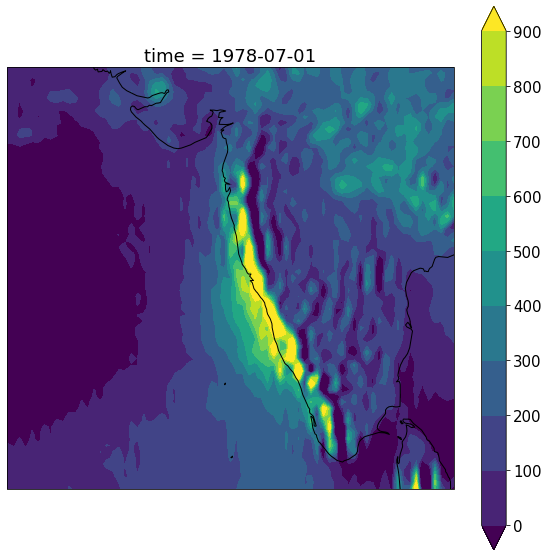

In [71]:
_,ax=plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
residual_itg_Wm2.plot.contourf(ax=ax,levels=np.arange(0,1000,100),cmap=plt.cm.viridis,transform=ccrs.PlateCarree())
ax.coastlines()

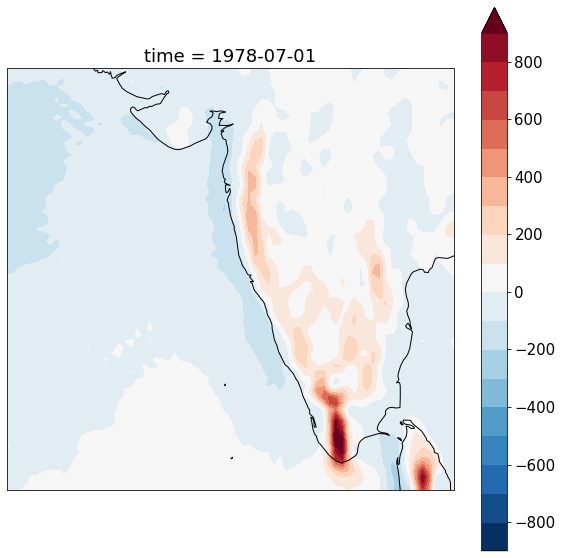

In [75]:
_,ax=plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
(1004.*compute_vertical_integral(udTdx,ps)/9.81).plot.contourf(ax=ax,levels=np.arange(-900,1000,100),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()

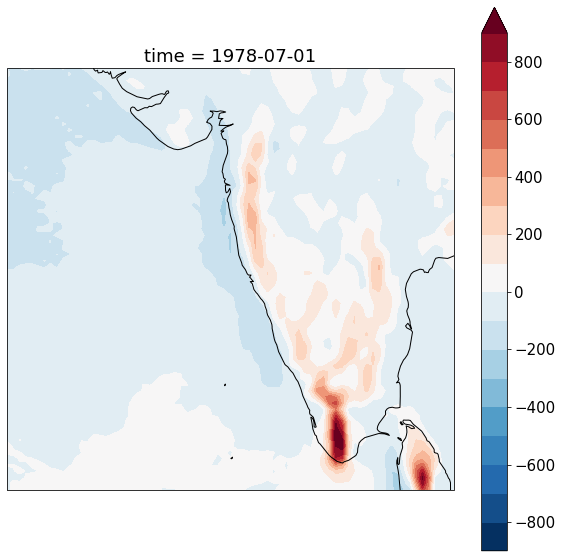

In [145]:
_,ax=plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
(1004.*compute_vertical_integral(udTdx+vdTdy,ps)/9.81).plot.contourf(ax=ax,levels=np.arange(-900,1000,100),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()

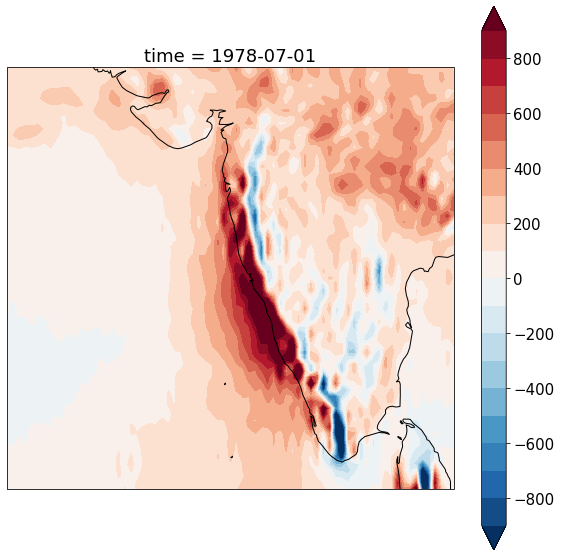

In [76]:
_,ax=plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
(1004.*compute_vertical_integral(omegadsdp,ps)/9.81).plot.contourf(ax=ax,levels=np.arange(-900,1000,100),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
ax.coastlines()

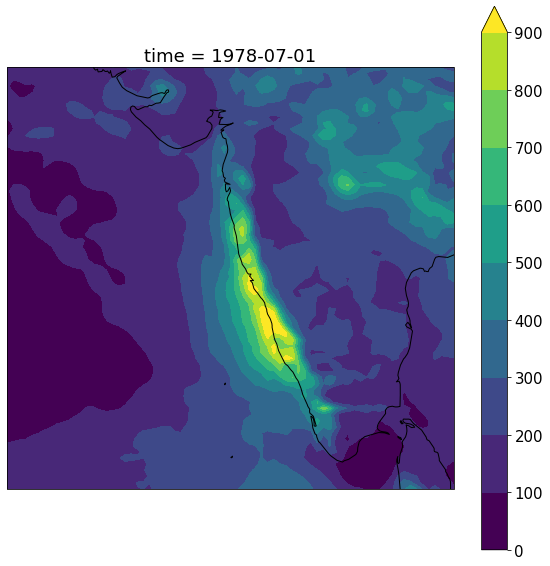

In [53]:
_,ax=plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
(pr_Wm2+ netradiative+sfcfluxes).plot.contourf(ax=ax,levels=np.arange(0,1000,100),transform=ccrs.PlateCarree())
ax.coastlines()

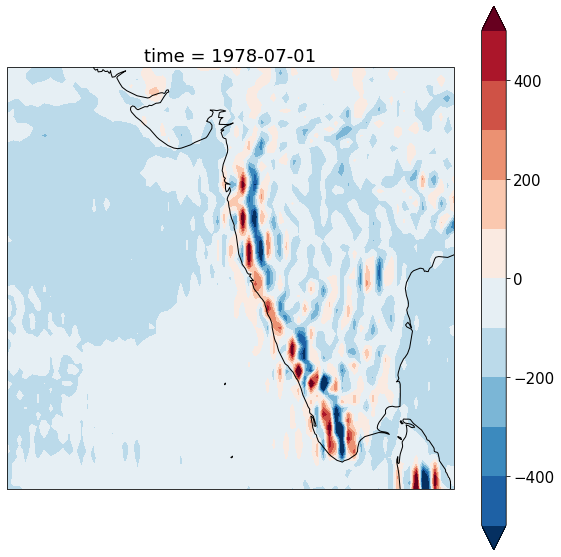

In [72]:
_,ax=plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
(residual_itg_Wm2-(pr_Wm2+ netradiative+sfcfluxes)).plot.contourf(ax=ax,levels=np.arange(-500,600,100),transform=ccrs.PlateCarree())
ax.coastlines()

## In the lower troposphere

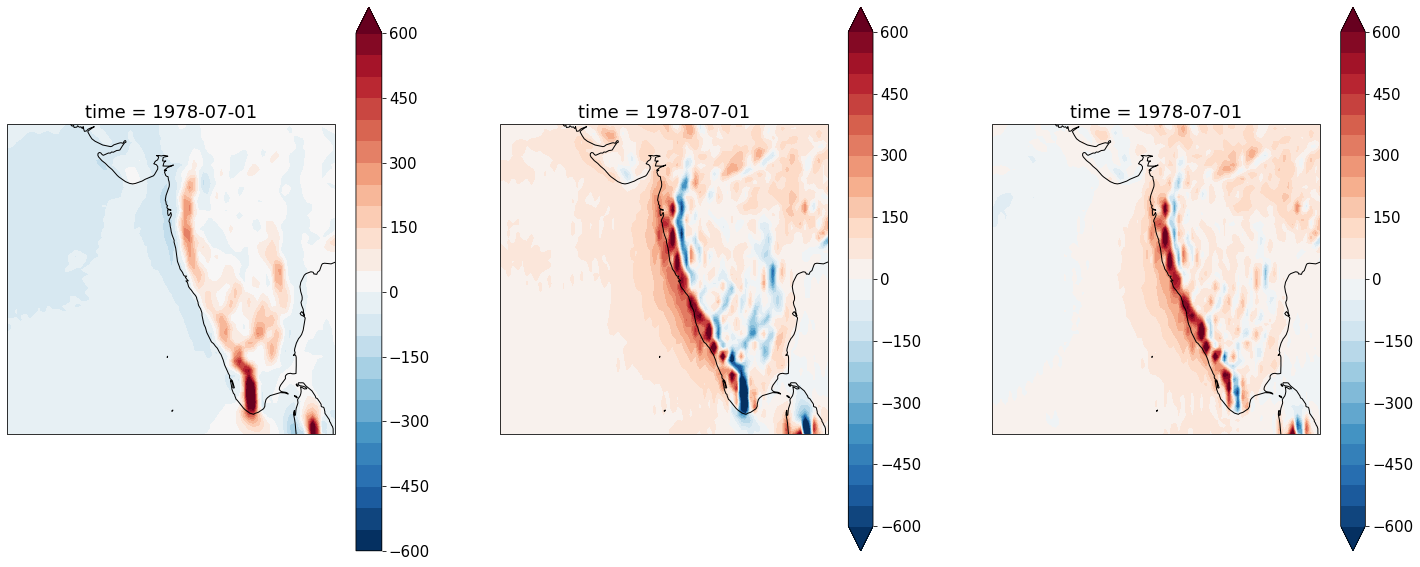

In [143]:
_,axs=plt.subplots(1,3,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
udTdx_L = (1004.*udTdx.sel(level=slice(700.,900.)).integrate('level')*100/9.81)
omegadsdp_L = (1004.*omegadsdp.sel(level=slice(700.,900.)).integrate('level')*100/9.81)

udTdx_L.plot.contourf(ax=axs[0],levels=np.arange(-600,610,50),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
omegadsdp_L.plot.contourf(ax=axs[1],levels=np.arange(-600,610,50),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
(omegadsdp_L+udTdx_L).plot.contourf(ax=axs[2],levels=np.arange(-600,610,50),cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())

for ax in axs:
    ax.coastlines()

# Diagnosing $\omega_d$


In [146]:
dsdp = s.differentiate('level')/100
omegad = -(udTdx+vdTdy)/dsdp# DSE budget

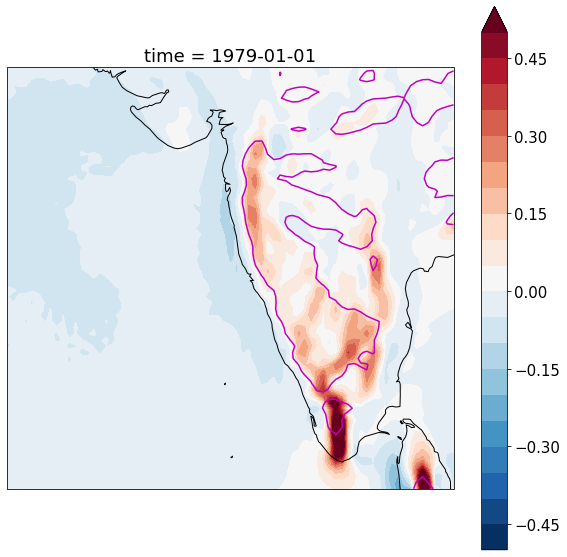

In [156]:
_,ax=plt.subplots(1,1,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
omegad.sel(level=slice(700,900)).mean('level').plot.contourf(ax=ax,levels=np.linspace(-0.5,0.5,21),transform=ccrs.PlateCarree())
sel_box(orogm,Ghats.box).plot.contour(levels=[500.],colors=['m'])
ax.coastlines()

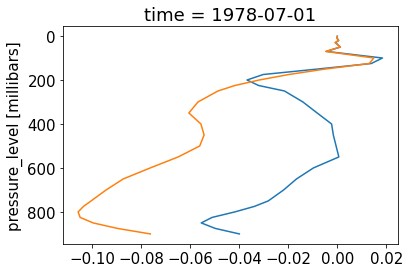

In [165]:
spatial_mean(omegad,mask=tilted_rect(omegad,*Ghats.box_tilted,reverse=True)).sel(level=slice(0,900)).plot(y='level',yincrease=False)
spatial_mean(w,mask=tilted_rect(omegad,*Ghats.box_tilted,reverse=True)).sel(level=slice(0,900)).plot(y='level',yincrease=False)


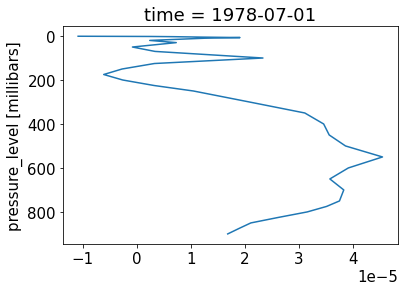

In [166]:
spatial_mean(udTdx+vdTdy+omegadsdp,mask=tilted_rect(omegad,*Ghats.box_tilted,reverse=True)).sel(level=slice(0,900)).plot(y='level',yincrease=False)


# q budget ?

## Functions

In [4]:
from tools.e5tools import *;from tools.generalTools import *
def p_k_half_era5(ps):
    """Given a surface pressure in Pa,
    return the pressure level p_{k+1/2} from which to compute the surface part 
    of the integral (see SeagerHenderson2013 - eq (22))
    args :
     - ps (float) : surface pressure in Pa
     
     Namely, finds the pressure levels p_k and p_{k+1} such that pk <= ps < p_{k+1}
     and returns (p_k + p_{k+1})/2; if ps >= 1e5 Pa = 1000 hPa, returns 1e5 Pa
    """
    plevs = 100.*np.array([1., 2., 3., 5., 7., 10., 20., 30., 50., 70.,
        100., 125., 150., 175., 200., 225., 250., 300., 350., 400.,
        450., 500., 550., 600., 650., 700., 750., 775., 800., 825.,
        850., 875., 900., 925., 950., 975., 1000.])
    
    return (plevs[np.searchsorted(plevs,ps)-1]+
            plevs[np.minimum(np.searchsorted(plevs,ps),len(plevs)-1)])/2



In [5]:
def compute_mc_terms(q,u,v,w,ps):
    uq = u*q  
    uq_vinteg = ((uq*(100*uq.level<ps)).integrate("level")*100 +
                 (uq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half_era5,ps))  
                 )#sfc_term = uq_k * (p_s - p_{k+1/2})
                )
    
    vq = v*q  
    vq_vinteg = ((vq*(100*vq.level<ps)).integrate("level")*100 +
                 (vq.sel(level = ps/100, method = 'ffill')*
                  (ps-xr.apply_ufunc(p_k_half_era5,ps))  
                 )#sfc_term = vq_k * (p_s - p_{k+1/2})
                )
    
    mc   = - divergence(uq_vinteg,vq_vinteg)/(9.81*1000)*1000*86400
    
    #minimum surface pressure of the neighboring elements of each grid cell
    psa = np.array(ps )
    psa_n = np.amin(np.array([psa,np.roll(psa,(1,0)),np.roll(psa,(-1,0)),np.roll(psa,(0,1)),np.roll(psa,(0,-1))]),axis=0) 
    ps_n = xr.DataArray(psa_n,ps.coords)
    
    #Mean wind convergence = -<q*div(u)>
    ddp_w = w.differentiate("level",edge_order=2)/100.
    conv_term = (q*ddp_w*(100*ddp_w.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    #conv_term 2 = -(q  *divergence(u  ,v  )*(100*q.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    
    #Minus moisture advection = -<u.grad(q)>
    adv_term  = -((u*ddx(q)+v*ddy(q))*(100*u.level<ps_n)).integrate("level")*100./(9.81*1000)*1000*86400
    
    #surface contribution
    sfc_term = mc -conv_term-adv_term
    return mc ,conv_term,adv_term,sfc_term

In [6]:
t=time.time()
q_tmean_climatology  = e5_climatology('128_133_q' ,(2010,2011,2012))
u_tmean_climatology  = e5_climatology('128_131_u' ,(2010,2011,2012))
v_tmean_climatology  = e5_climatology('128_132_v' ,(2010,2011,2012))
w_tmean_climatology  = e5_climatology('128_135_w' ,(2010,2011,2012))
ps_tmean_climatology = e5_climatology('128_134_sp',(2010,2011,2012))

38.54519534111023
42.92583656311035
47.308884143829346
46.87161660194397
1.8473868370056152


In [7]:
e5_pr_climatology = e5_climatology('128_228_tp' ,(2010,2011,2012))*1e3

1.9703483581542969


In [10]:
for MR in MRs:
    print(MR.name)
    q = sel_box_months(q_tmean_climatology ,MR.box,MR.months)
    u = sel_box_months(u_tmean_climatology ,MR.box,MR.months)
    v = sel_box_months(v_tmean_climatology ,MR.box,MR.months)
    w = sel_box_months(w_tmean_climatology ,MR.box,MR.months)
    ps = sel_box_months(ps_tmean_climatology,MR.box,MR.months)
    MR.vars['PR'] = sel_box_months(e5_pr_climatology   ,MR.box,MR.months)
    MR.vars['MC'],MR.vars['CONV'],MR.vars['ADV'],MR.vars['SFC'] = compute_mc_terms(q ,u ,v ,w ,ps)

ghats
myanmar
vietnam
malaysia
philippines
newbritain


## Moisture budgets plots

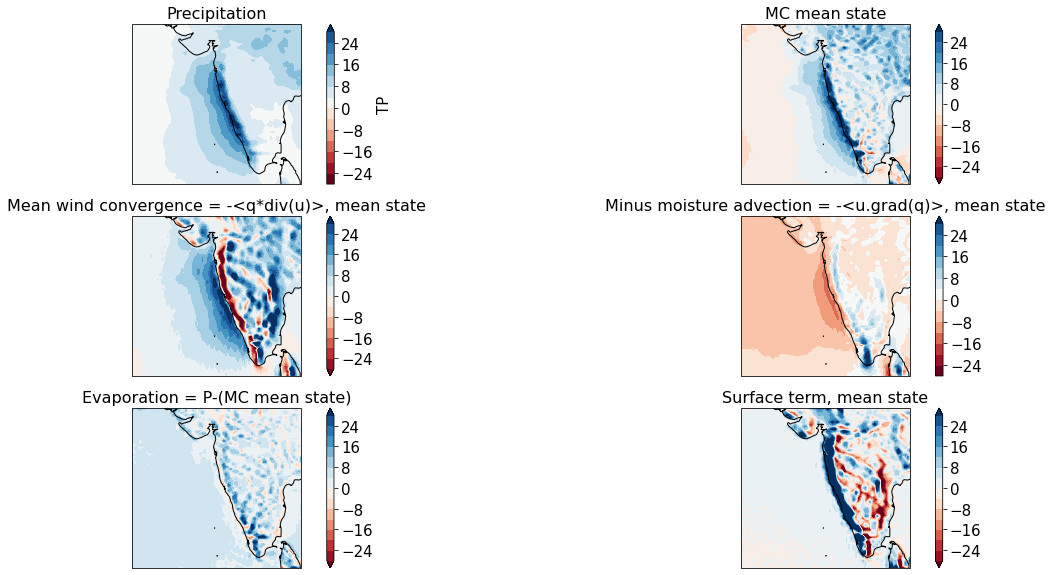

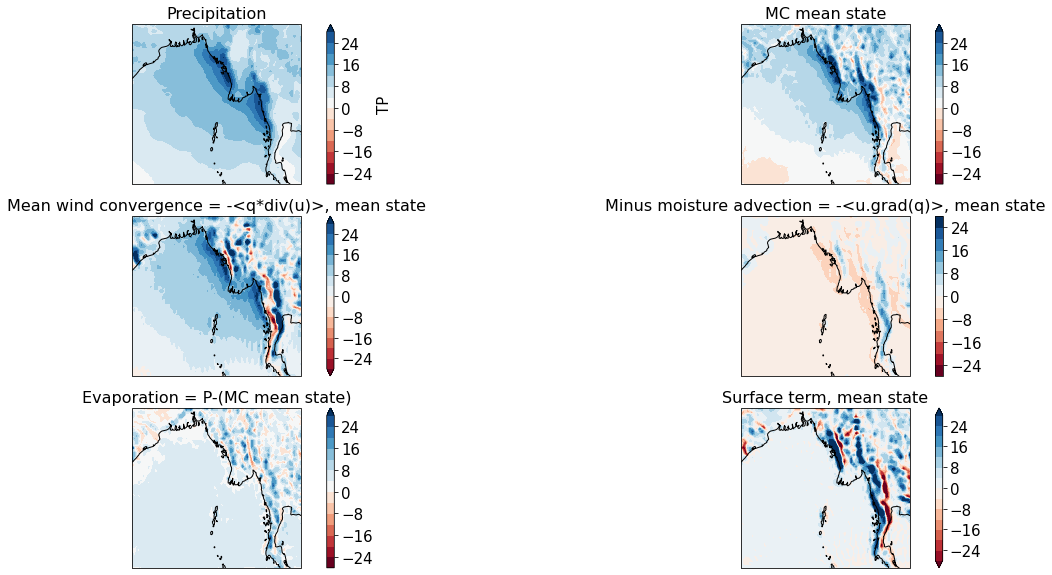

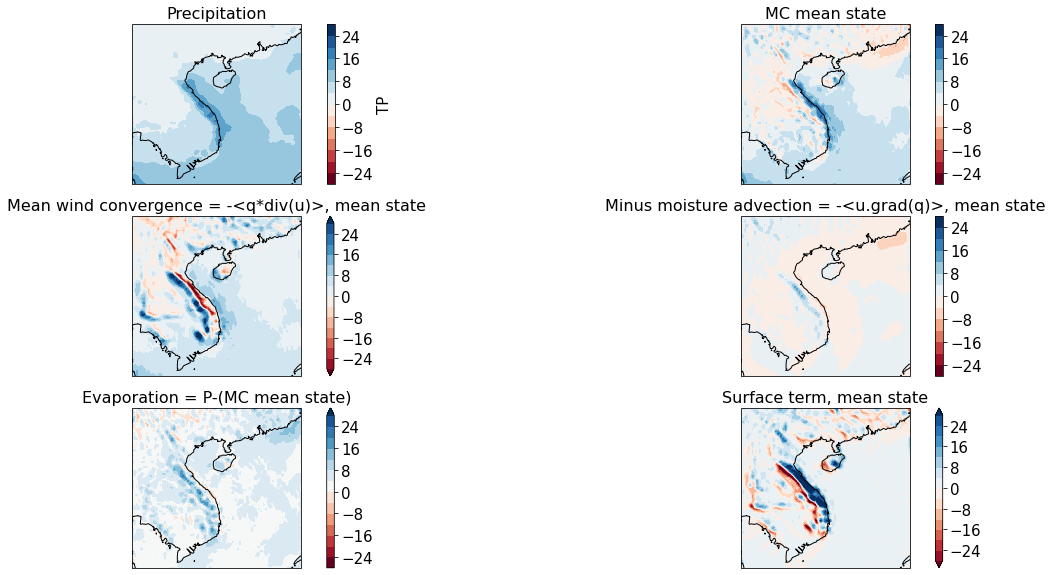

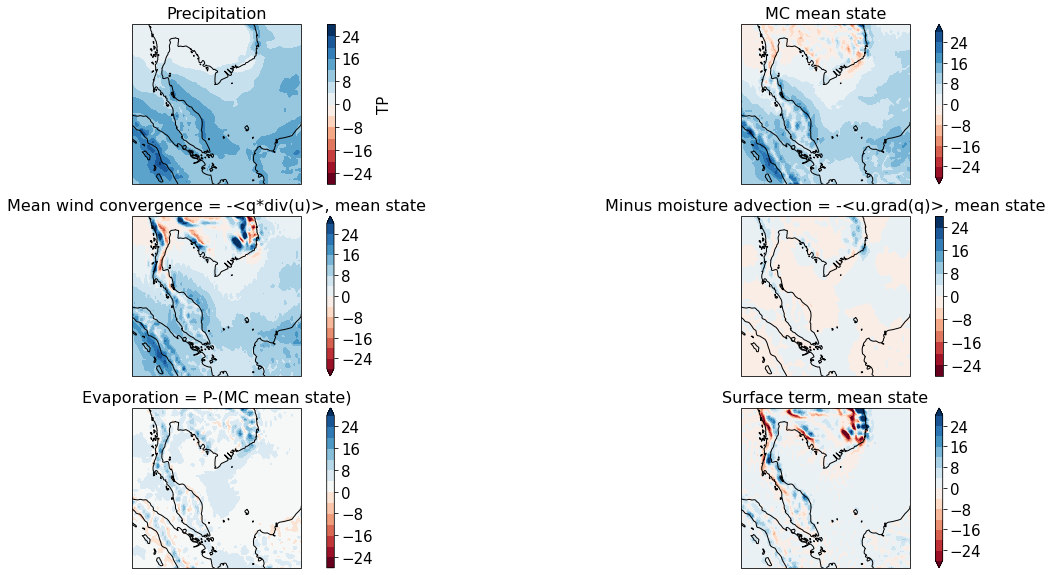

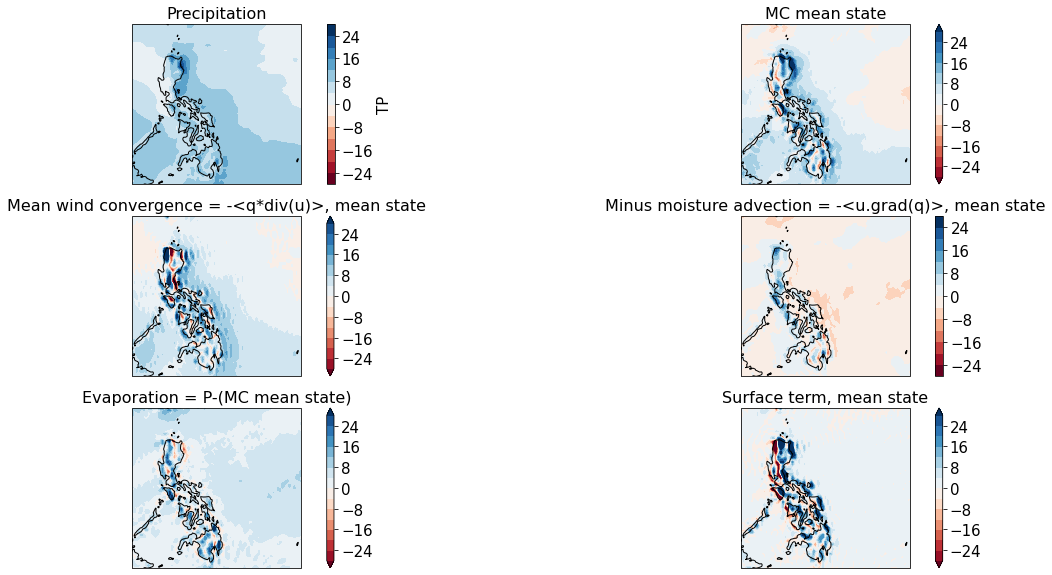

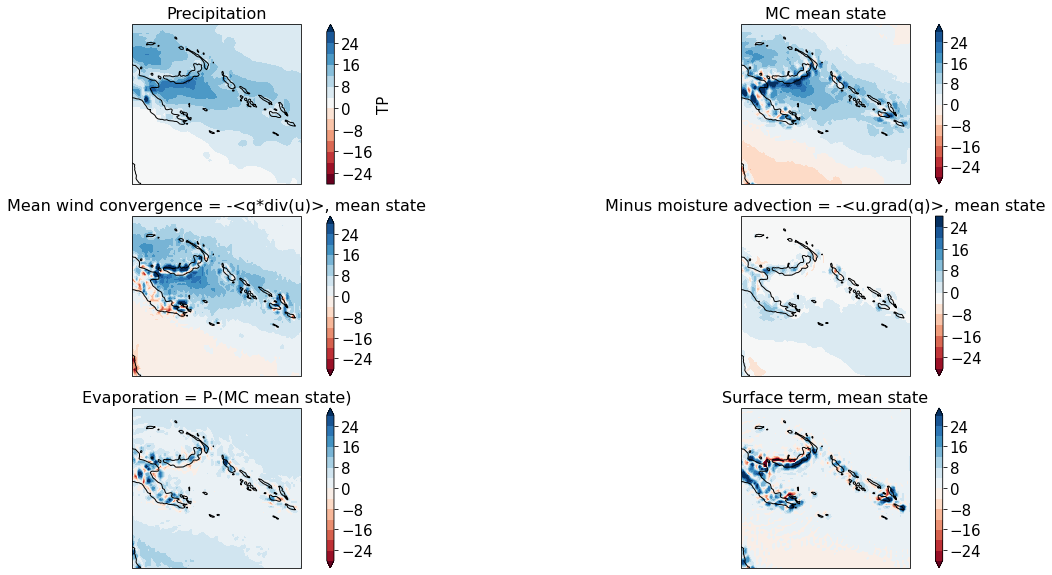

In [12]:
for MR in MRs:
    fig, axs = plt.subplots(3,2,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})
    axs=axs.reshape(-1)
    lvls = np.arange(-28.,31.,4.)
    for var,ax in zip((MR.vars['PR'],MR.vars['MC'],MR.vars['CONV'],MR.vars['ADV'],MR.vars['PR']-MR.vars['MC'],MR.vars['SFC']),axs):
        var.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=lvls,cmap=plt.cm.RdBu)
        ax.coastlines()
    axs[0].set_title("Precipitation",fontsize=16)
    axs[1].set_title("MC mean state",fontsize=16)
    axs[2].set_title("Mean wind convergence = -<q*div(u)>, mean state",fontsize=16)
    axs[3].set_title("Minus moisture advection = -<u.grad(q)>, mean state",fontsize=16)
    axs[4].set_title("Evaporation = P-(MC mean state)",fontsize=16)
    axs[5].set_title("Surface term, mean state",fontsize=16)
    

## Lower-tropospheric moisture budgets?

In [32]:
def compute_lowertrop_mc_terms(q,u,v,w,ps):
    lid = 600.
    floor=900.
    
    uq = u*q  
    uq_vinteg = uq.sel(level=slice(lid,floor)).integrate("level")*100
    
    vq = v*q  
    vq_vinteg = vq.sel(level=slice(lid,floor)).integrate("level")*100
    
    mc   = - divergence(uq_vinteg,vq_vinteg)/(9.81*1000)*1000*86400
    
    #Mean wind convergence = -<q*div(u)>
    ddp_w = w.differentiate("level",edge_order=2)/100.
    conv_term = (q*ddp_w).sel(level=slice(lid,floor)).integrate("level")*100./(9.81*1000)*1000*86400

    #Minus moisture advection = -<u.grad(q)>
    adv_term  = -((u*ddx(q)+v*ddy(q)).sel(level=slice(lid,floor))).integrate("level")*100./(9.81*1000)*1000*86400
    
    #surface contribution
    res_term = mc -conv_term-adv_term
    return mc ,conv_term,adv_term,res_term


In [33]:
for MR in MRs:
    print(MR.name)
    q = sel_box_months(q_tmean_climatology ,MR.box,MR.months)
    u = sel_box_months(u_tmean_climatology ,MR.box,MR.months)
    v = sel_box_months(v_tmean_climatology ,MR.box,MR.months)
    w = sel_box_months(w_tmean_climatology ,MR.box,MR.months)
    ps = sel_box_months(ps_tmean_climatology,MR.box,MR.months)
    MR.vars['MC_L'],MR.vars['CONV_L'],MR.vars['ADV_L'],MR.vars['RES_L'] = compute_lowertrop_mc_terms(q ,u ,v ,w ,ps)

ghats
myanmar
vietnam
malaysia
philippines
newbritain


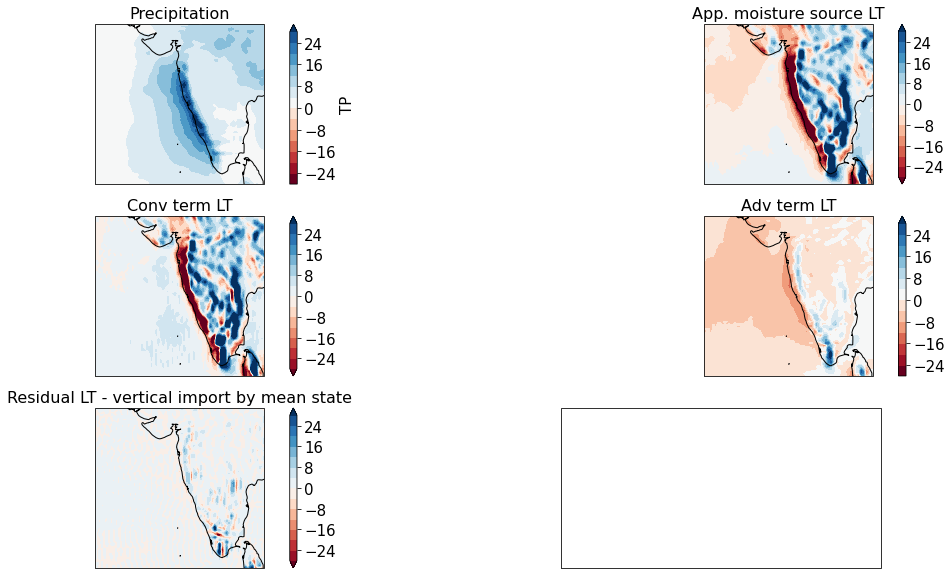

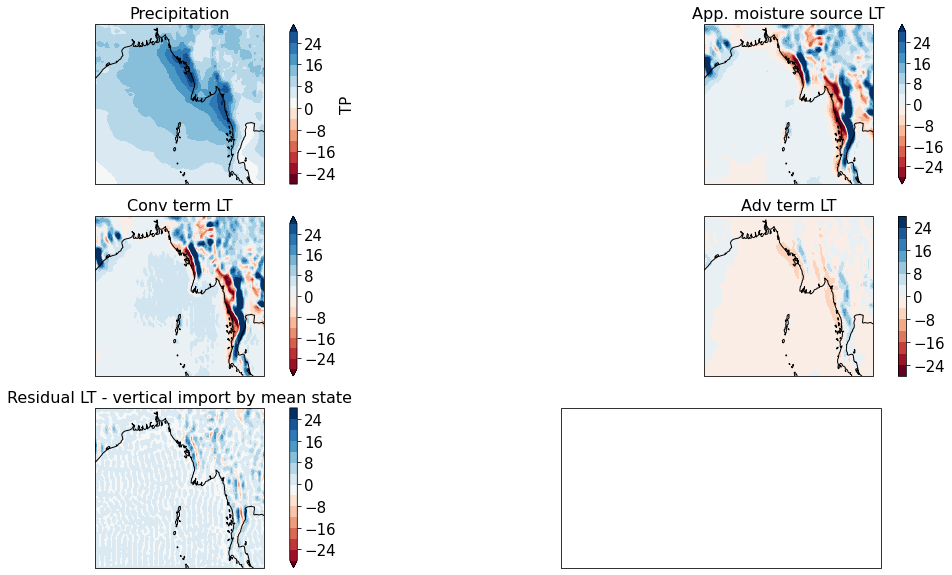

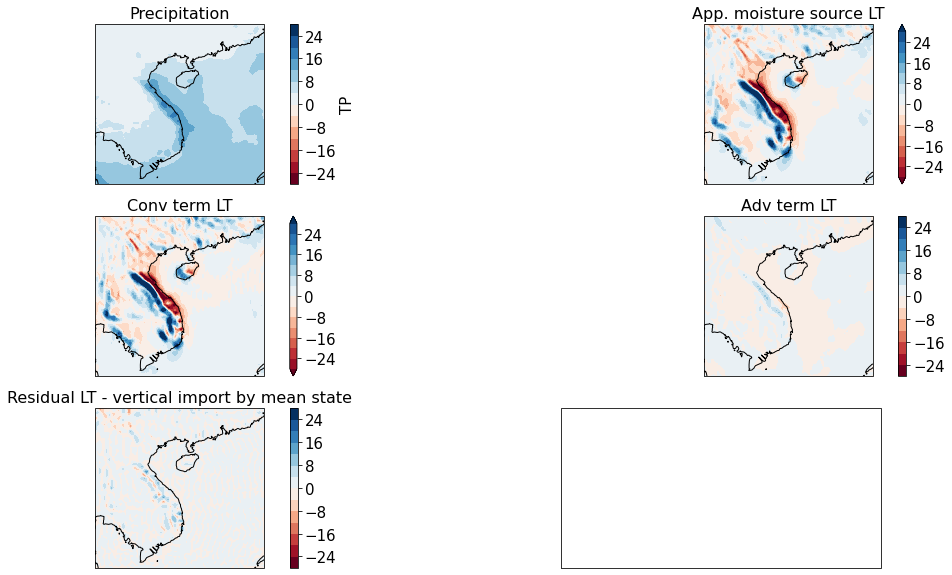

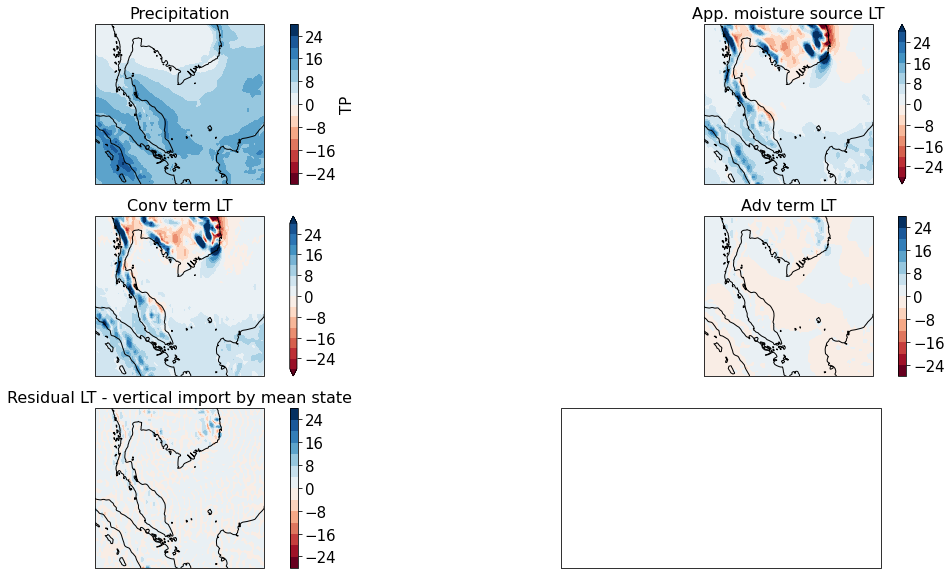

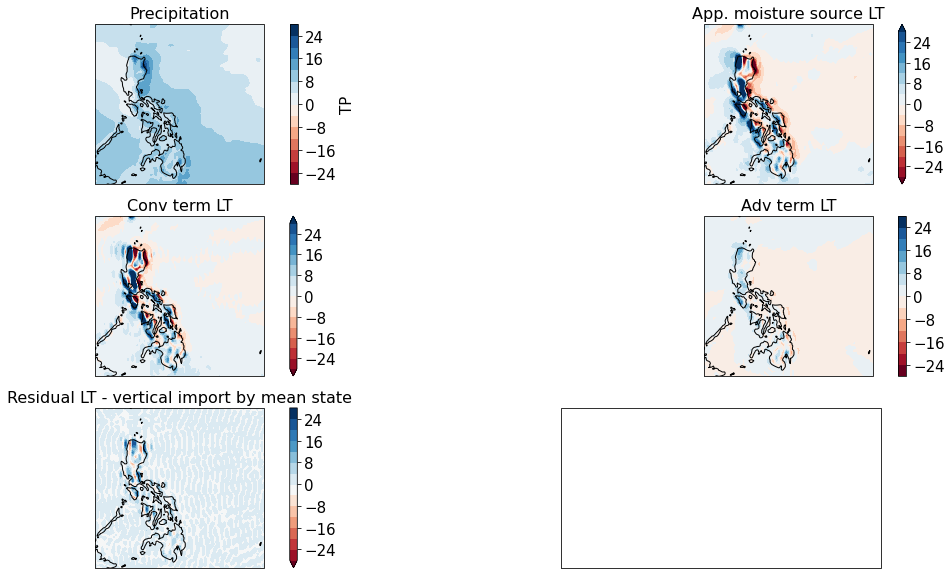

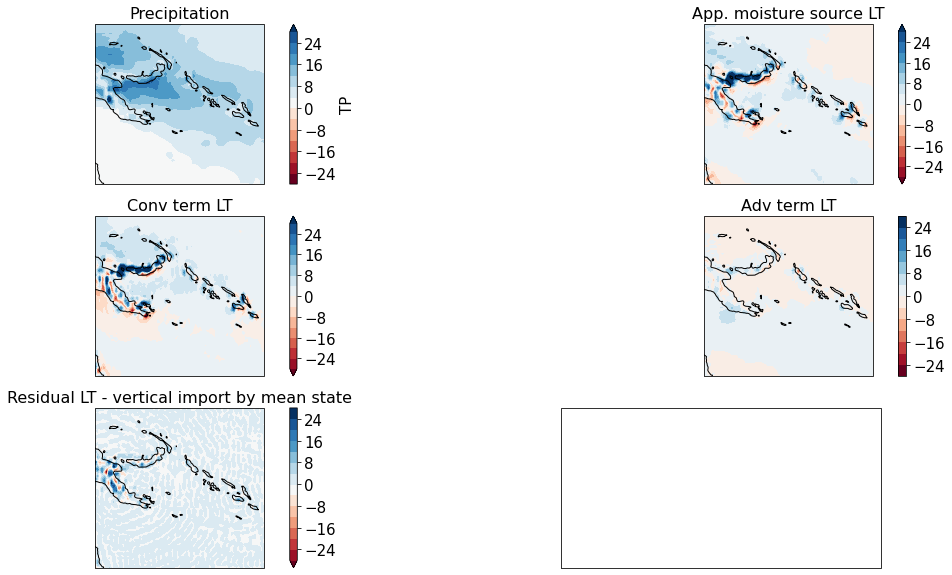

In [34]:
for MR in MRs:
    fig, axs = plt.subplots(3,2,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})
    axs=axs.reshape(-1)
    lvls = np.arange(-28.,31.,4.)
    for var,ax in zip((MR.vars['PR'],MR.vars['MC_L'],MR.vars['CONV_L'],MR.vars['ADV_L'],MR.vars['RES_L']),axs):
        var.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=lvls,cmap=plt.cm.RdBu)
        ax.coastlines()
    axs[0].set_title("Precipitation",fontsize=16)
    axs[1].set_title("App. moisture source LT",fontsize=16)
    axs[2].set_title("Conv term LT",fontsize=16)
    axs[3].set_title("Adv term LT",fontsize=16)
    axs[4].set_title("Residual LT - vertical import by mean state",fontsize=16)
    